In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from scipy import integrate, stats
import scipy
import time
import warnings
import copy
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from numpy import random
import random as rnd
import math
from tqdm import tqdm 
import tabulate
from numba import njit, jit
from sympy import Interval
from matplotlib.lines import Line2D
import scipy.stats as st
import enum 
from IPython.display import display, HTML
# warnings.filterwarnings("ignore", category=RuntimeWarning)

## Some notes for functions used:
- plotterBS and plotterHES help to visualise the parameter variations in BlackScholes and Heston simulations respectively.
- The parameters for Heston are varied around the parameters we put in the last week's slide.
- The functions mainCalculation and mainCalculationHES additionaly return the correction terms, which is given by $\text{Price}_{\text{Milstein}}-\text{Price}_{\text{Euler}}$. So a positive correction means milstein errors are higher and vice versa. This will help when interpreting the plots.

In [2]:
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
# Black-Scholes option prices
def blackschol(S0, K, sigma, r, T, optiontype='put', barrier=False, H=-1):
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    d1 = (1 / (sigma * np.sqrt(T)))*( np.log(S0/K) + (r + (sigma**2/2))*(T))
    d2 = (1 / (sigma * np.sqrt(T)))*( np.log(S0/K) + (r - (sigma**2/2))*(T))
    c = norm.cdf(d1)* S0 - norm.cdf(d2)* K * np.exp(-r *(T))
    p = norm.cdf(-1*d2) * K * np.exp(-r *(T))  - norm.cdf(-1*d1)* S0 
    
    if barrier:
        assert H!=-1 , 'Enter a Barrier price'
        assert not H>=S0, 'Enter a Barrier less than S0'
        lamda = (r+(sigma**2/2))/sigma**2
        x1 = (np.log(S0/H)/(sigma*np.sqrt(T))) + lamda*sigma*np.sqrt(T)
        y = (np.log(H**2/(S0*K))/(sigma*np.sqrt(T))) + lamda*sigma*np.sqrt(T)
        y1 = (np.log(H/S0)/(sigma*np.sqrt(T))) + lamda*sigma*np.sqrt(T)
        p_di = -S0*norm.cdf(-x1) + K*np.exp(-r*T)*norm.cdf(-x1+sigma*np.sqrt(T)) + S0*(H/S0)**(2*lamda)*(norm.cdf(y)-norm.cdf(y1)) -K*np.exp(-r*T)*(H/S0)**(2*lamda-2)*(norm.cdf(y-sigma*np.sqrt(T))-norm.cdf(y1-sigma*np.sqrt(T)))
        c_di = S0*(H/S0)**(2*lamda)*norm.cdf(y) - K*np.exp(-r*T)*(H/S0)**(2*lamda-2)*norm.cdf(y-sigma*np.sqrt(T))
        c_do = S0*norm.cdf(x1) - K*np.exp(-r*T)*norm.cdf(x1-sigma*np.sqrt(T)) - S0*(H/S0)**(2*lamda)*norm.cdf(y1) + K*np.exp(-r*T)*(H/S0)**(2*lamda-2)*norm.cdf(y1-sigma*np.sqrt(T))
        
        if optiontype=='put':
            if H >= K:
                return 0
            else:
                return p - p_di 
        else:
            if H <= K:
                return c - c_di
            else:
                return c_do
            
    else:
        if optiontype == 'call':
            return c 
        else:
            return p 

def GeneratePathsGBMEuler(NoOfPaths,NoOfSteps,T,r,sigma,S_0):    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
   
    # Euler Approximation
    S1 = np.zeros([NoOfPaths, NoOfSteps+1])
    S1[:,0] =S_0
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        
        S1[:,i+1] = S1[:,i] + r * S1[:,i]* dt + sigma * S1[:,i] * (W[:,i+1] - W[:,i])
        time[i+1] = time[i] +dt
        
    # Retun S1 and S2
    paths = {"time":time,"S":S1}
    return paths


def GeneratePathsGBMMilstein(NoOfPaths,NoOfSteps,T,r,sigma,S_0):    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
   
    # Milstein Approximation
    S1 = np.zeros([NoOfPaths, NoOfSteps+1])
    S1[:,0] =S_0
       
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        
        S1[:,i+1] = S1[:,i] + r * S1[:,i]* dt + sigma * S1[:,i] * (W[:,i+1] - W[:,i]) + 0.5 * sigma **2.0 * S1[:,i] * (np.power((W[:,i+1] - W[:,i]),2) - dt)
        time[i+1] = time[i] +dt
        
    # Retun S1 and S2
    paths = {"time":time,"S":S1}
    return paths


def EUOptionPriceFromMCPaths(CP,S,K,T,r):
    # S is a vector of Monte Carlo samples at T
    if CP == OptionType.CALL:
        return (np.exp(-r*T)*np.mean(np.maximum(S-K,0.0)), 
               np.std(np.exp(-r*T)*np.maximum(S-K,0.0),ddof=1)/np.sqrt(len(S)))
    elif CP == OptionType.PUT:
        return (np.exp(-r*T)*np.mean(np.maximum(K-S,0.0)), 
               np.std(np.exp(-r*T)*np.maximum(K-S,0.0),ddof=1)/np.sqrt(len(S)))
    

def BarrierOptionPriceFromMCPaths(CP,S,K,T,r,H):
    # condition for DO option
    indicator = 1*(S.min(axis=1) > H) 
    # S is an array prices with no. of Monte Carlo paths as rows and time points as columns 
    if CP == OptionType.CALL: 
        return (np.exp(-r*T)*np.mean(np.maximum(S[:,-1]-K,0.0)*indicator),  
               np.std(np.exp(-r*T)*np.maximum(S[:,-1]-K,0.0)*indicator, ddof=1)/np.sqrt(len(S)))
    elif CP == OptionType.PUT:
        return (np.exp(-r*T)*np.mean(np.maximum(K-S[:,-1],0.0)*indicator), 
               np.std(np.exp(-r*T)*np.maximum(K-S[:,-1],0.0)*indicator, ddof=1)/np.sqrt(len(S)))
    

def mainCalculation(optiontype,steps, interest, vola , strike ,barrier, maturity = 1, paths=20000, seed=1):
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    if optiontype == 'put':
        CP= OptionType.PUT
    else:
        CP= OptionType.CALL
    T = maturity
    r = interest
    sigma = vola
    S0 = 100
    K = strike
    H = barrier
    NoOfSteps =steps
    
    # Simulated paths
    NoOfPathsTemp = paths
    
    # option price
    exactPrice = blackschol(S0, K, sigma, r, T, 'put')
    exactBarrierPrice = blackschol(S0, K,sigma,r,T,'put',True,H)

    np.random.seed(seed)
    PathsEuler    = GeneratePathsGBMEuler(NoOfPathsTemp,NoOfSteps,T,r,sigma,S0)
    np.random.seed(seed)
    PathsMilstein = GeneratePathsGBMMilstein(NoOfPathsTemp,NoOfSteps,T,r,sigma,S0)
    S_Euler = PathsEuler["S"]
    S_Milstein = PathsMilstein["S"]
    priceEuler, seEuler = EUOptionPriceFromMCPaths(CP,S_Euler[:,-1],K,T,r)
    priceMilstein, seMil = EUOptionPriceFromMCPaths(CP,S_Milstein[:,-1],K,T,r)
    correction_euro = priceMilstein - priceEuler
    barrierpriceEuler, seBarEuler = BarrierOptionPriceFromMCPaths(CP,S_Euler,K,T,r,H)
    barrierpriceMilstein, seBarMil = BarrierOptionPriceFromMCPaths(CP,S_Milstein,K,T,r,H)
    correction_bar = barrierpriceMilstein - barrierpriceEuler
        
    return (abs(priceEuler-exactPrice), abs(priceMilstein-exactPrice), abs(barrierpriceEuler-exactBarrierPrice),
            abs(barrierpriceMilstein-exactBarrierPrice), seEuler, seMil, seBarEuler, seBarMil, correction_euro, correction_bar)

In [3]:
def generic_plotter(eulerBar_err, milBar_err, correction_barrier, param_grid, param_val, fig_title, 
                    euler_err=[], mil_err=[], correction_euro=[]):
    assert fig_title in ['gamma','kappa','rho','vbar','v0','r','sigma','barrier'], "fig_title should be ['gamma','kappa','rho','vbar','v0','r','sigma','barrier']"
    step_grid = [365,52,12,4]
    if fig_title!='barrier':
        assert len(euler_err)*len(mil_err)*len(correction_euro) != 0 , 'Provide euler and/or milstein errors and/or correction for european options'
        
        fig, axs = plt.subplots(nrows=1,ncols=2,dpi=150, figsize=(7,3))
        axs[0].plot(1/np.array(step_grid), euler_err, 'r*:', alpha=0.6, ms=5)
        axs[0].plot(1/np.array(step_grid), mil_err, 'r^-.', alpha=0.6, mfc='white', mec='red')
        axs[0].set_xlabel("$\Delta t$")
        axs[0].set_ylabel('Absolute errors',color='red',fontsize='small')
        axs[0].tick_params(axis='y', labelcolor='red',width=2)
        if param_val == param_grid[0]:
            axs[0].set_title('European options',fontsize=9)

        ax1 = axs[0].twinx() 
        #ax1.plot(1/np.array(step_grid), np.array(euler_err) - np.array(mil_err), 'b.--',alpha=0.5)
        ax1.plot(1/np.array(step_grid), correction_euro, 'b.--',alpha=0.5)

        ax1.set_xlabel("$\Delta t$")
        ax1.set_ylabel('',color='blue')
        ax1.tick_params(axis='y', labelcolor='blue',width=2)
        axs[0].grid()

        lns1 = axs[1].plot(1/np.array(step_grid), eulerBar_err, 'r*:', alpha=0.6, ms=5, label="Euler")
        lns2 = axs[1].plot(1/np.array(step_grid), milBar_err, 'r^-.' ,alpha=0.6, mfc='white', mec='red', label="Milstein")
        axs[1].set_xlabel("$\Delta t$")
        axs[1].set_ylabel('',color='red')
        axs[1].tick_params(axis='y', labelcolor='red',width=2)
        if param_val == param_grid[0]:
            axs[1].set_title('Barrier options',fontsize=9)

        ax2 = axs[1].twinx() 
        #ax2.plot(1/np.array(step_grid), np.array(eulerBar_err) - np.array(milBar_err), 'b.--',alpha=0.5,
             #label="Correction"+"\n"+"(Euler$-$Mil)")
        lns3 = ax2.plot(1/np.array(step_grid), correction_barrier, 'b.--',alpha=0.5, 
                        label="Correction"+"\n"+"(${Price}_{Milstein}-{Price}_{Euler}$)")
        ax2.set_xlabel("$\Delta t$")
        ax2.set_ylabel('Correction',color='blue',fontsize='small')
        ax2.tick_params(axis='y', labelcolor='blue',width=2)
        axs[1].grid()
        lns = lns1+lns2+lns3
        labs = [l.get_label() for l in lns]
        fig.legend(lns, labs, loc='upper center',  bbox_to_anchor=(0.5, -0.005), ncol=3, 
                      fancybox=True, shadow=True,fontsize='small') 

        if fig_title == 'r':
            fig.suptitle('$r={:.2f}\%$'.format(param_val*100), fontsize=10)
        elif fig_title == 'sigma':
            fig.suptitle('$\sigma={:.1f}\%$'.format(param_val*100), fontsize=10)
        elif fig_title == 'vbar':
            fig.suptitle('$\overline{v}={:.2f}$'.format(param_val), fontsize=10)
        elif fig_title == 'v0':
            fig.suptitle('$\v_0={:.2f}$'.format(param_val), fontsize=10)
        else:
            fig.suptitle('$\{}={:.1f}$'.format(fig_title,param_val), fontsize=10)
        plt.tight_layout()
        plt.show() 
    
    else:
        fig, ax = plt.subplots(dpi=150,figsize=(3,2))
        lns1 = ax.plot(1/np.array(step_grid), eulerBar_err, 'r*:', alpha=0.6, ms=5, label="Euler error")
        lns2 = ax.plot(1/np.array(step_grid), milBar_err, 'r^-.', alpha=0.6, mfc='white', mec='red', label="Milstein error")
        ax.set_xlabel("$\Delta t$")
        ax.set_ylabel('Absolute error',color='red',fontsize='small')
        ax.tick_params(axis='y', labelcolor='red')
        ax.grid()

        ax.set_title('Barrier={}'.format(param_val),fontsize=9)

        ax1 = ax.twinx() 
        #ax1.plot(1/np.array(step_grid), np.array(eulerBar_err) - np.array(milBar_err), 'b.--',alpha=0.5, 
             #label="Correction"+"\n"+"(Euler$-$Mil)")
        lns3 = ax1.plot(1/np.array(step_grid), correction_barrier, 'b.--',alpha=0.5,
                 label="Correction"+"\n"+"(${Price}_{Milstein}-{Price}_{Euler}$)")
        ax1.set_xlabel("$\Delta t$")
        ax1.set_ylabel('Correction',color='blue',fontsize='small')
        ax1.tick_params(axis='y', labelcolor='blue')
        lns = lns1+lns2+lns3
        labs = [l.get_label() for l in lns]
        fig.legend(lns, labs, loc='upper center',  bbox_to_anchor=(0.5, -0.05), ncol=3, 
                      fancybox=True, shadow=True,fontsize='small')
        plt.show()

## Sequentially vary the parameteres for Black Scholes

In [4]:
def plotterBS(vary_interest=True, vary_vola=False, vary_bar=False):
    step_grid = [365,52,12,4]
    if vary_interest:
        intrest_grid = np.linspace(0.0015, 0.05, 7)
        title = "Fixed params: $\sigma=20\%,H=80$"
        display(HTML('<font size="6"><strong>{}</font></strong>'.format(title)))
        for r in intrest_grid:
            err_eu, err_mil , errBar_eu, errBar_mil, correctionEuro, correctionBar = [], [], [], [], [], [] 
            for i in step_grid:
                temp_eu, temp_mil, tempBar_eu, tempBar_mil, tempCorrection, tempBarCorrection = [], [], [], [], [], []
                for j in range(10):
                    res = mainCalculation(optiontype='put',steps=i,interest=r,vola=0.2,strike=100,barrier=80, 
                                          maturity=1, paths=200000, seed=np.random.randint(1,100)) 

                    temp_eu.append(res[0])
                    temp_mil.append(res[1])
                    tempBar_eu.append(res[2])
                    tempBar_mil.append(res[3])
                    tempCorrection.append(res[8])
                    tempBarCorrection.append(res[9])

                err_eu.append(np.mean(temp_eu))
                err_mil.append(np.mean(temp_mil)) 
                errBar_eu.append(np.mean(tempBar_eu))
                errBar_mil.append(np.mean(tempBar_mil))
                correctionEuro.append(np.mean(tempCorrection))
                correctionBar.append(np.mean(tempBarCorrection))
        
            generic_plotter(euler_err=err_eu, mil_err=err_mil,correction_euro = correctionEuro,
                            eulerBar_err=errBar_eu, milBar_err=errBar_mil, correction_barrier = correctionBar,
                            param_grid=intrest_grid, param_val=r, fig_title='r')

    if vary_vola:
        vola_grid = np.linspace(0.1, 0.5, 9)
        title = "Fixed params: $r=1\%,H=80$"
        display(HTML('<font size="6"><strong>{}</font></strong>'.format(title)))
        for v in vola_grid:
            err_eu, err_mil , errBar_eu, errBar_mil, correctionEuro, correctionBar = [], [], [], [], [], [] 
            for i in step_grid:
                temp_eu, temp_mil, tempBar_eu, tempBar_mil, tempCorrection, tempBarCorrection = [], [], [], [], [], []
                for j in range(10):
                    res = mainCalculation(optiontype='put',steps=i,interest=0.01,vola=v,strike=100,barrier=80, 
                                          maturity=1, paths=200000, seed=np.random.randint(1,100)) 

                    temp_eu.append(res[0])
                    temp_mil.append(res[1])
                    tempBar_eu.append(res[2])
                    tempBar_mil.append(res[3])
                    tempCorrection.append(res[8])
                    tempBarCorrection.append(res[9])

                err_eu.append(np.mean(temp_eu))
                err_mil.append(np.mean(temp_mil)) 
                errBar_eu.append(np.mean(tempBar_eu))
                errBar_mil.append(np.mean(tempBar_mil))
                correctionEuro.append(np.mean(tempCorrection))
                correctionBar.append(np.mean(tempBarCorrection))
        
            generic_plotter(euler_err=err_eu, mil_err=err_mil,correction_euro = correctionEuro, eulerBar_err=errBar_eu, 
                            milBar_err=errBar_mil, correction_barrier = correctionBar, param_grid=vola_grid, 
                            param_val=v, fig_title='sigma')    
            
    if vary_bar:
        bar_grid = np.linspace(80, 99, 9, dtype=int)
        title = "Fixed params: $r=1\%,\sigma=35\%$"
        display(HTML('<font size="6"><strong>{}</font></strong>'.format(title)))
        for h in bar_grid:
            errBar_eu, errBar_mil, correctionBar = [], [], [] 
            for i in step_grid:
                tempBar_eu, tempBar_mil, tempBarCorrection = [], [], []
                for j in range(10):
                    res = mainCalculation(optiontype='put',steps=i,interest=0.01,vola=0.35,strike=100,barrier=h, 
                                          maturity=1, paths=200000, seed=np.random.randint(1,100)) 

                    tempBar_eu.append(res[2])
                    tempBar_mil.append(res[3])
                    tempBarCorrection.append(res[9])

                errBar_eu.append(np.mean(tempBar_eu))
                errBar_mil.append(np.mean(tempBar_mil))
                correctionBar.append(np.mean(tempBarCorrection))
        
            generic_plotter(eulerBar_err=errBar_eu, milBar_err=errBar_mil, correction_barrier = correctionBar,
                            param_grid=bar_grid, param_val=h, fig_title='barrier')     
            
    else:
        print('All parameters were set False. Set anyone to True!!')

#### Zhiyu

### Vary interest. 

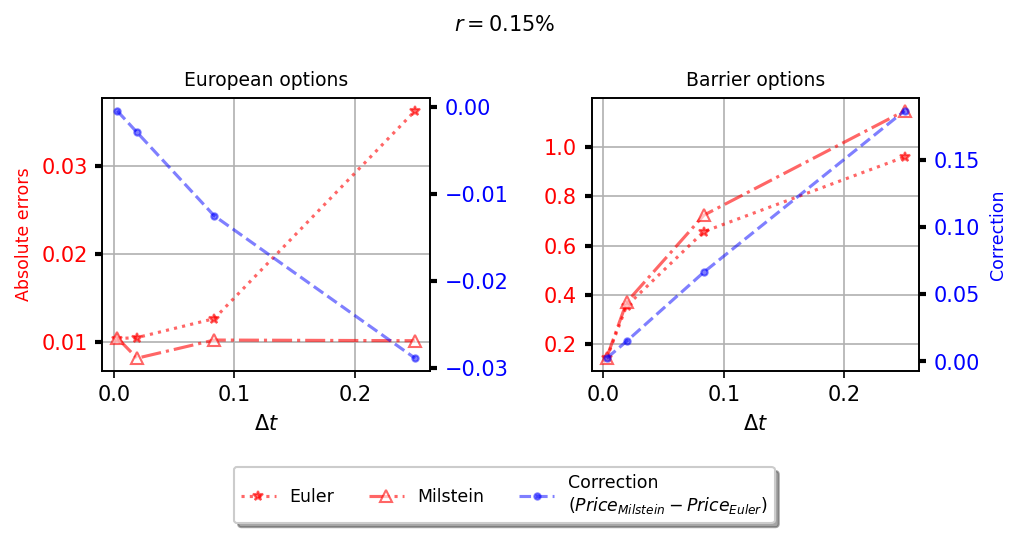

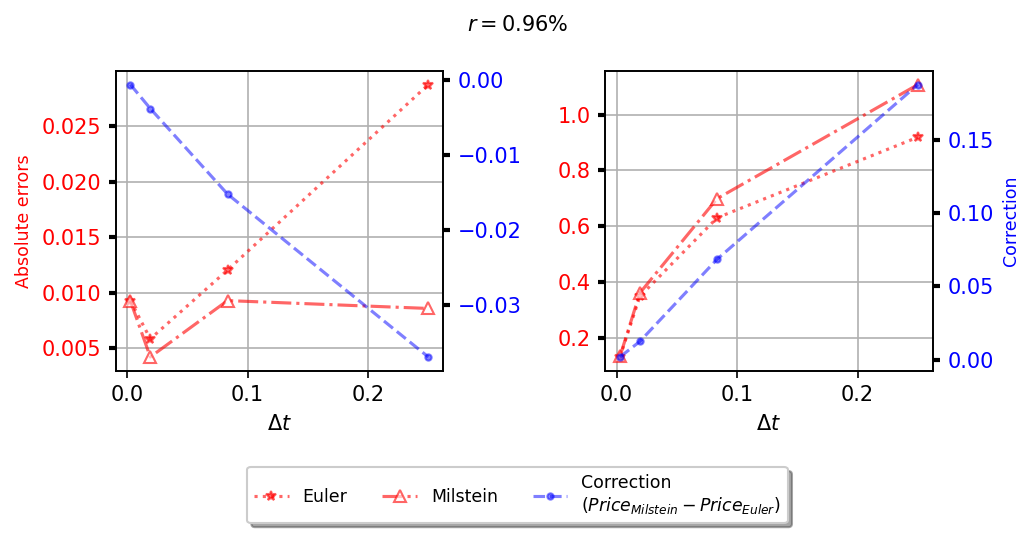

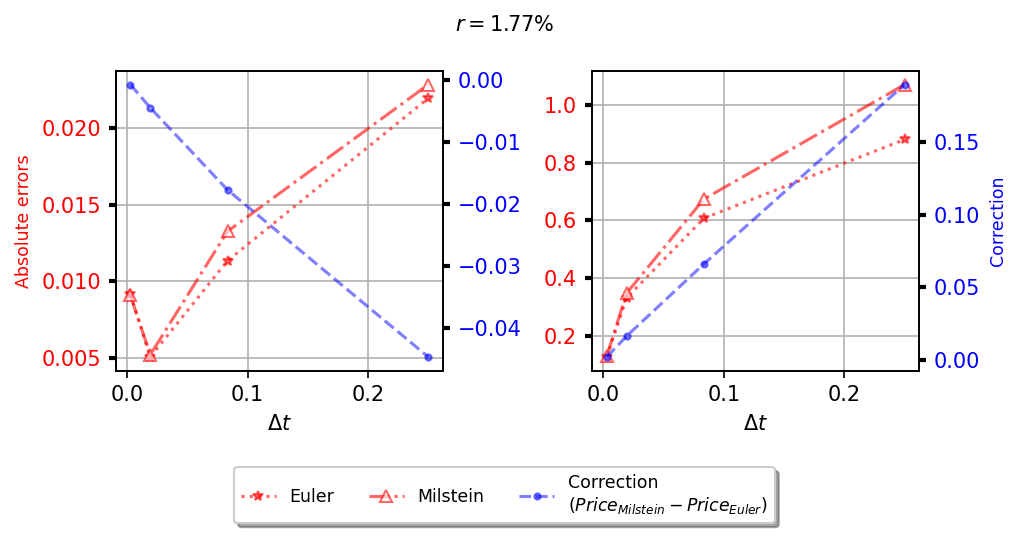

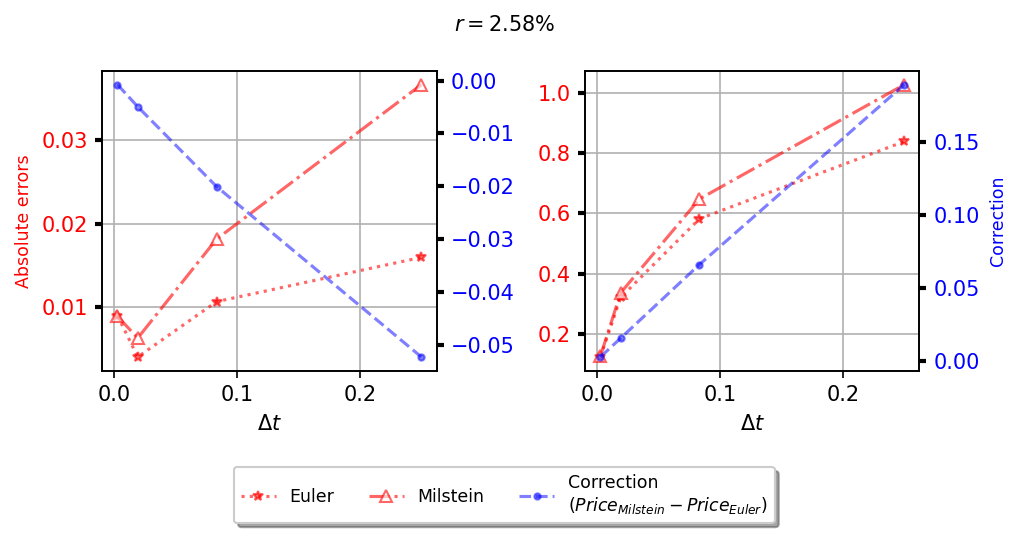

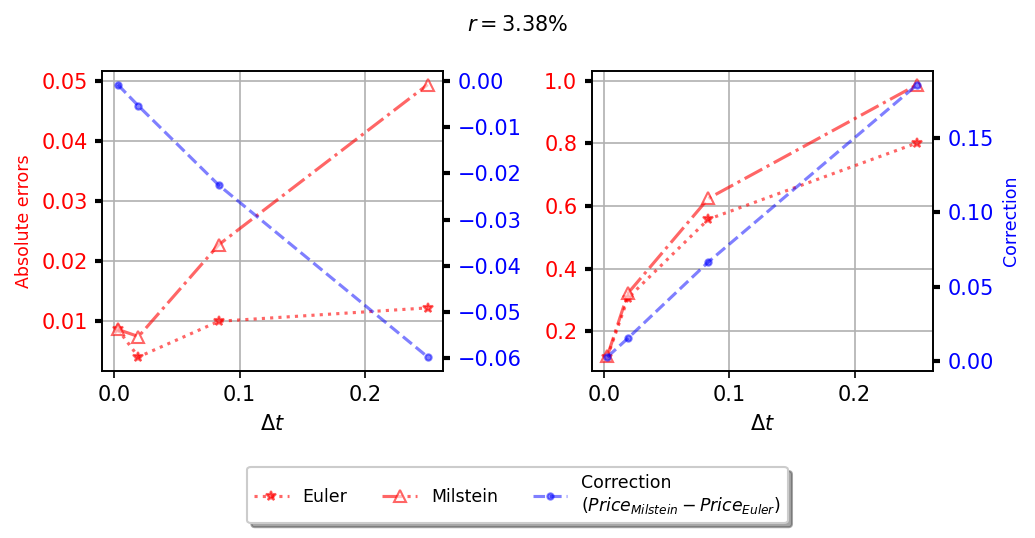

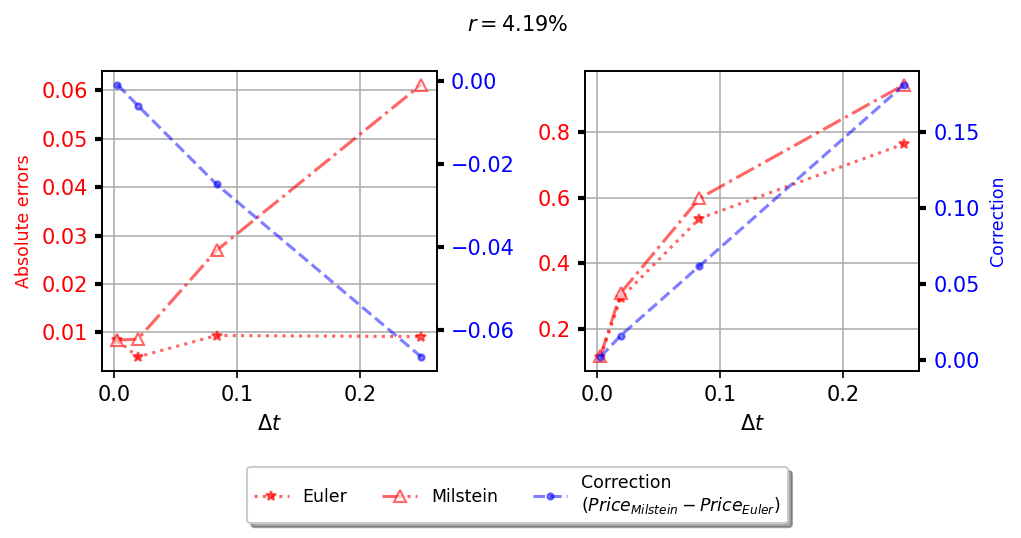

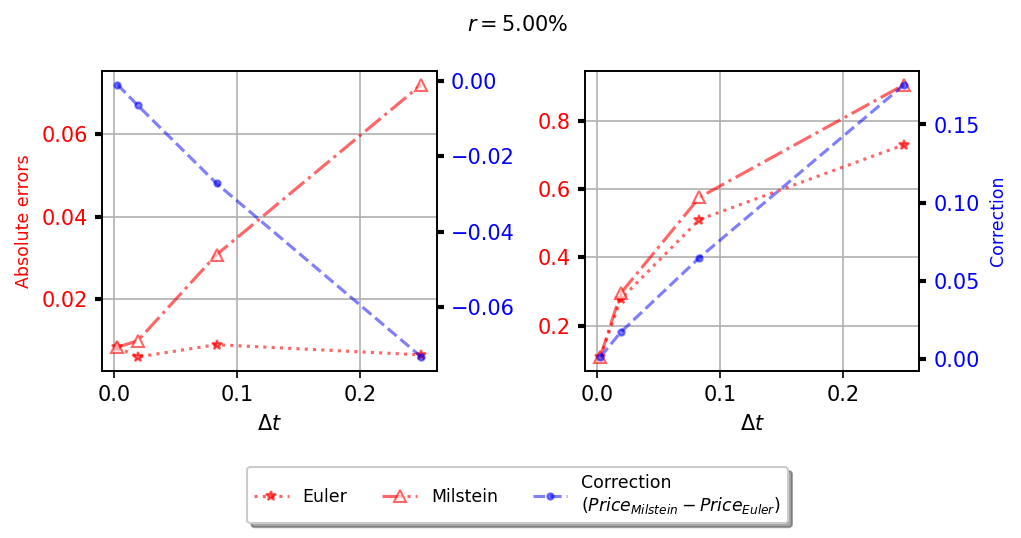

All parameters were set False. Set anyone to True!!


In [5]:
plotterBS(vary_interest=True)

#### Zhiyu

### Vary volatility. 

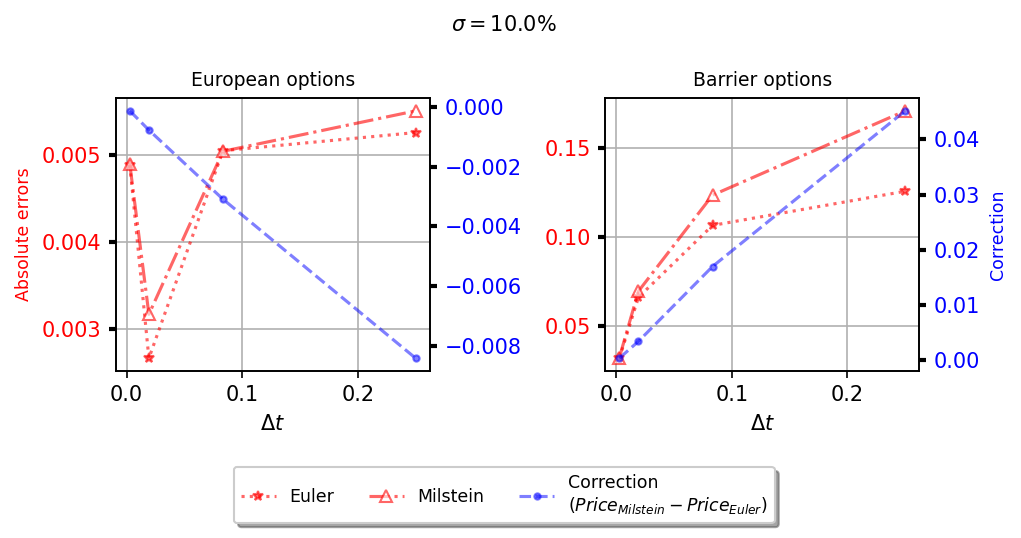

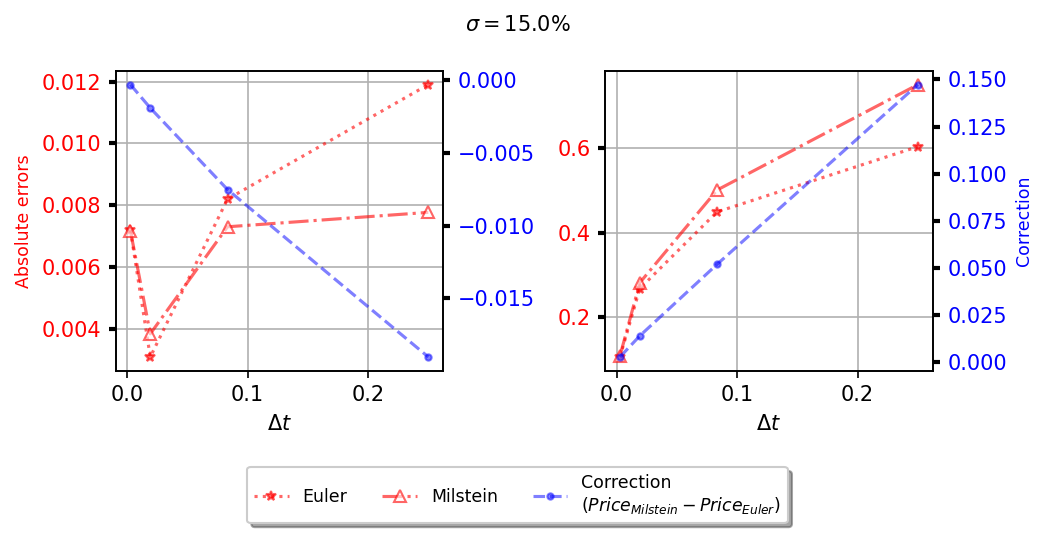

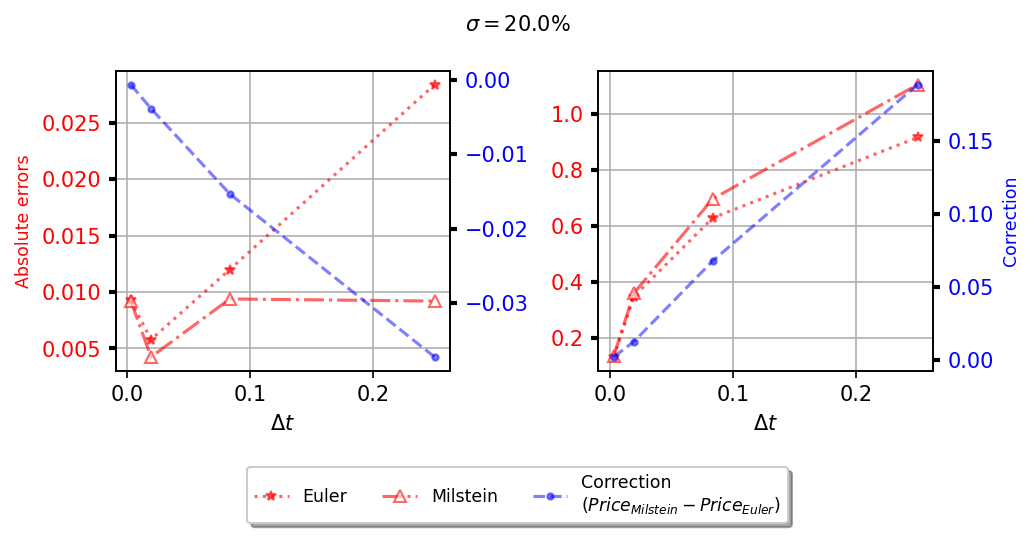

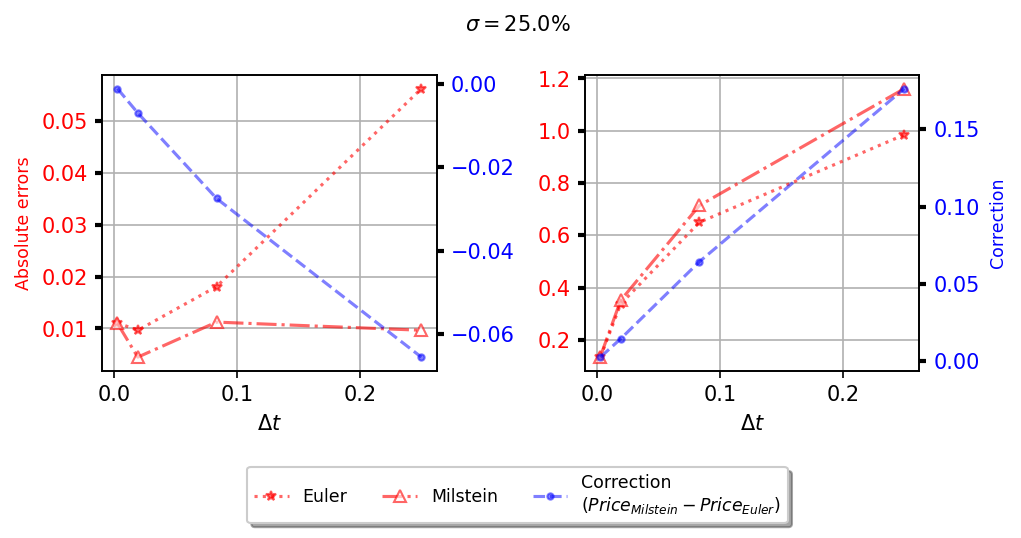

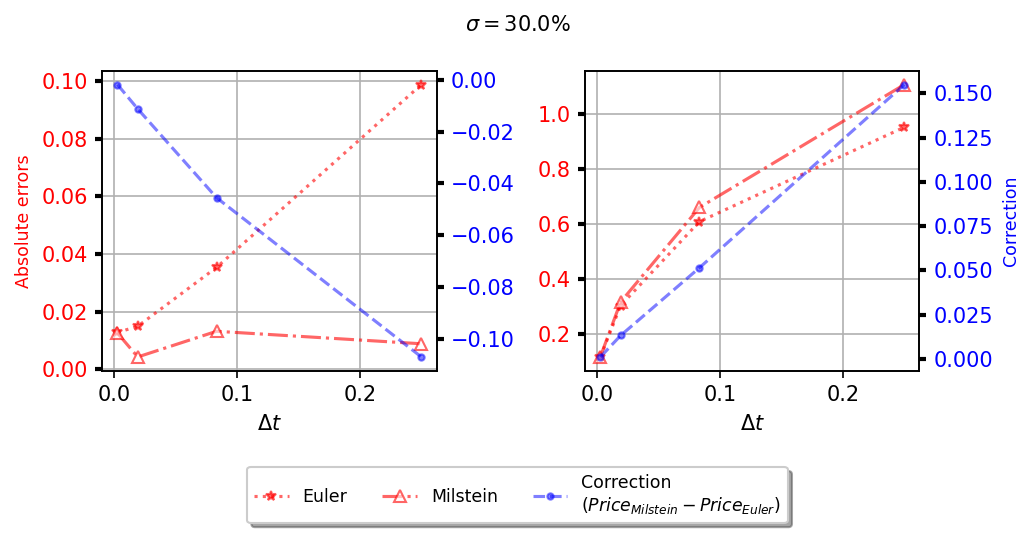

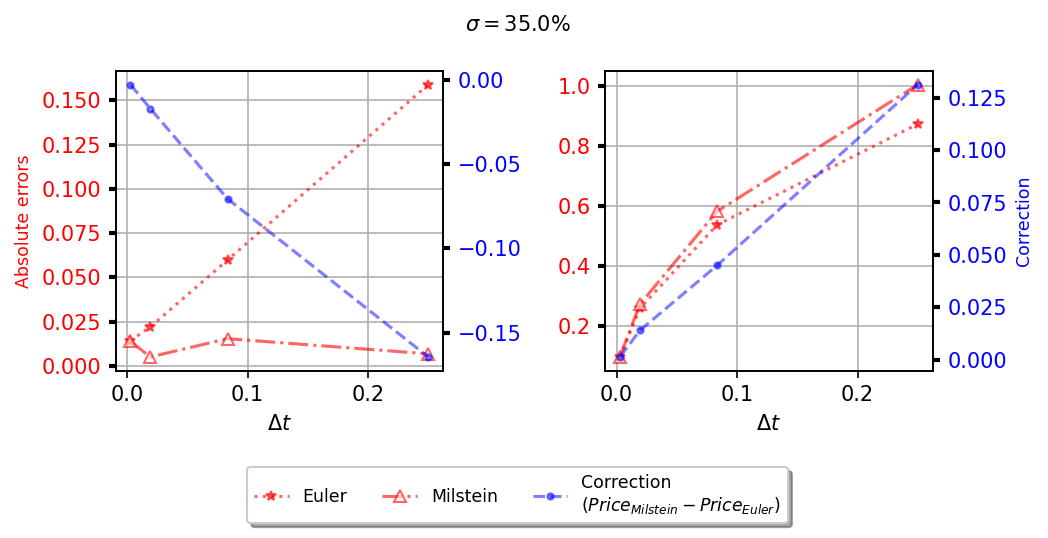

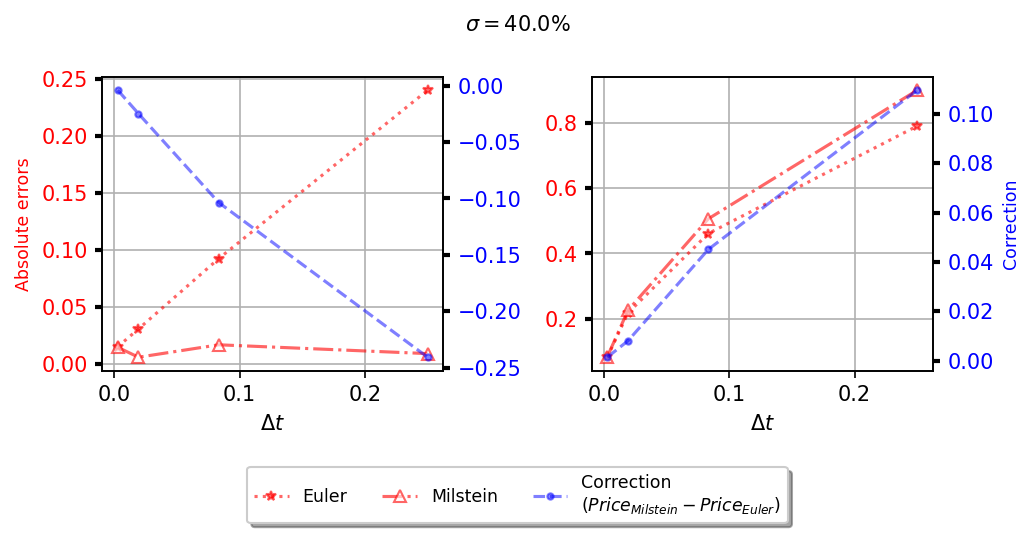

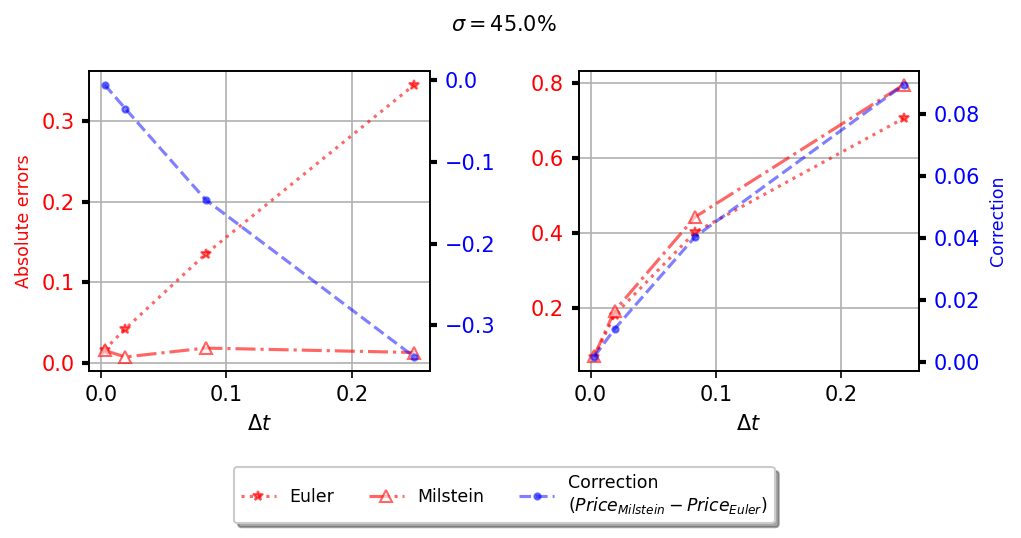

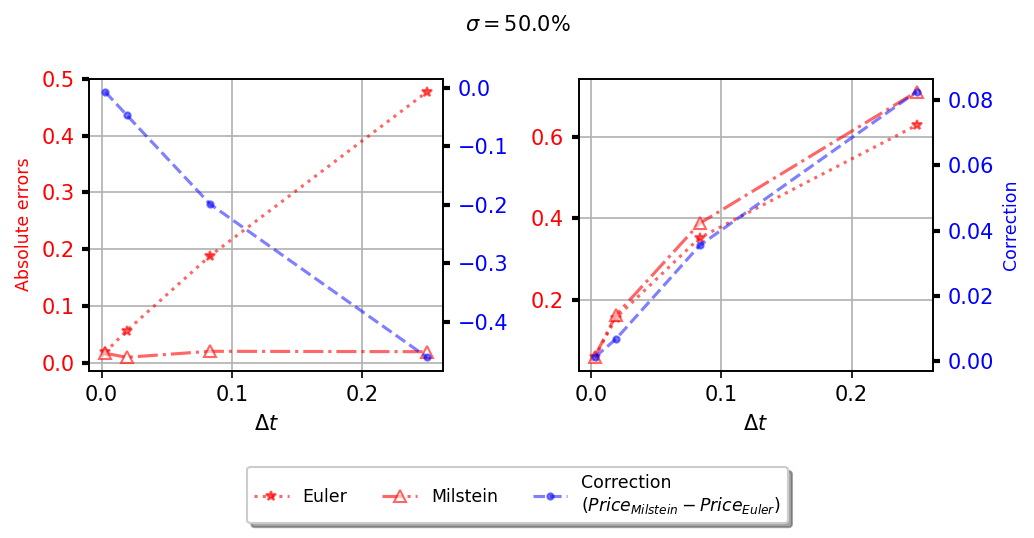

All parameters were set False. Set anyone to True!!


In [6]:
plotterBS(vary_interest=False,vary_vola=True)

#### Zhiyu

### Vary barrier. 
**Note: - Only the barrier options are shown since the European options dont depend on barrier.**

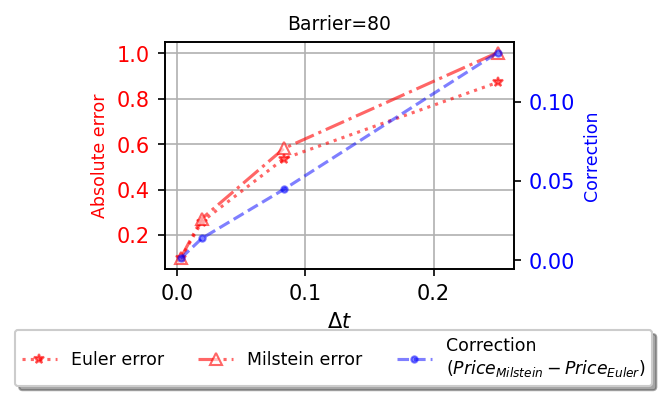

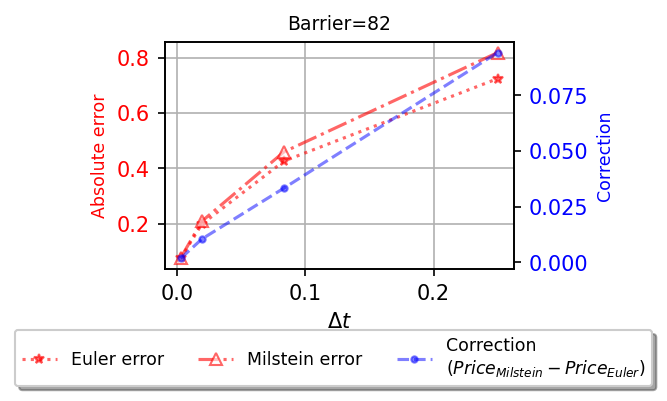

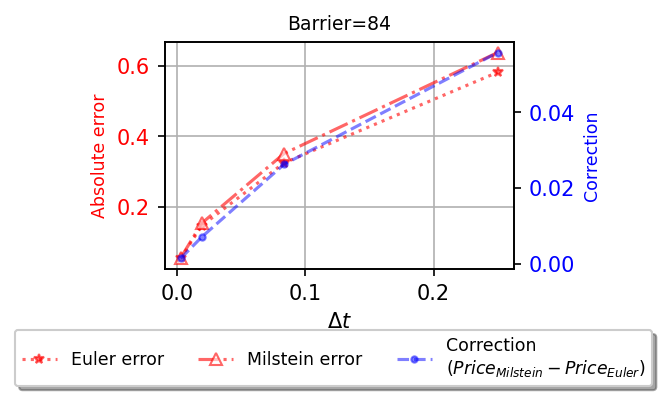

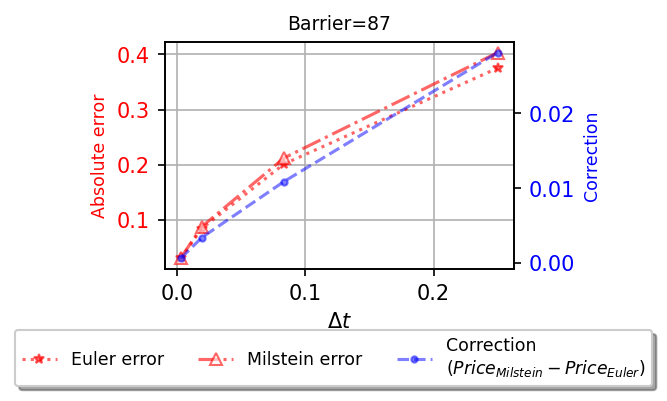

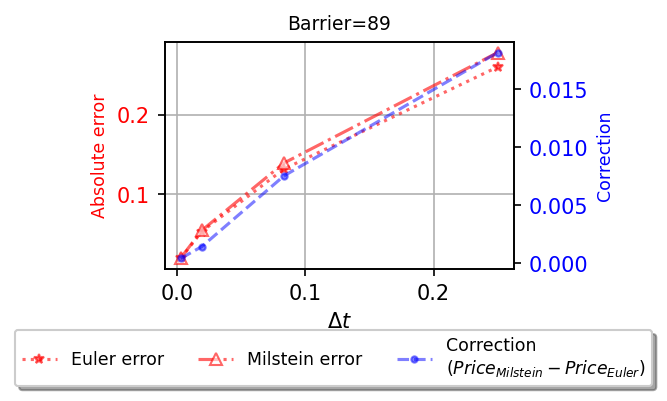

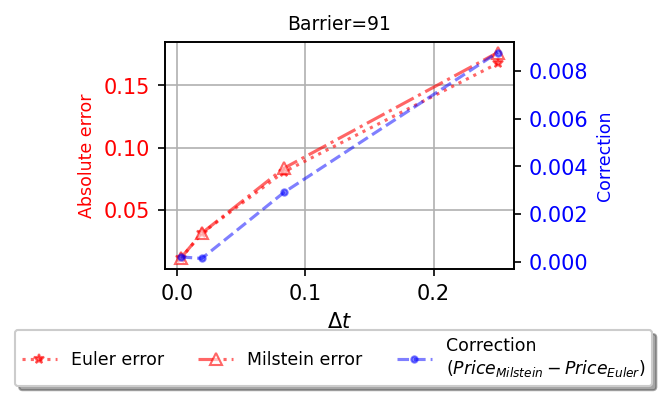

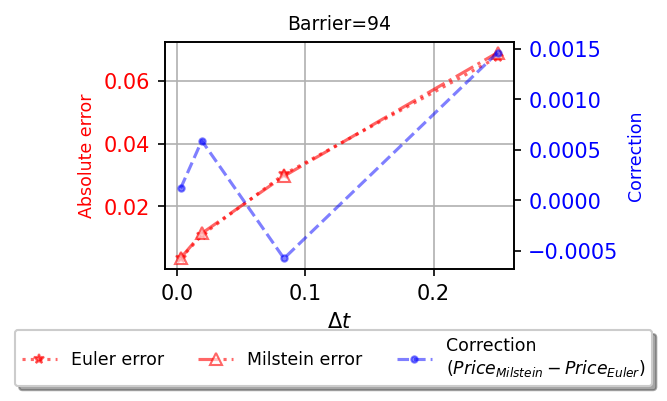

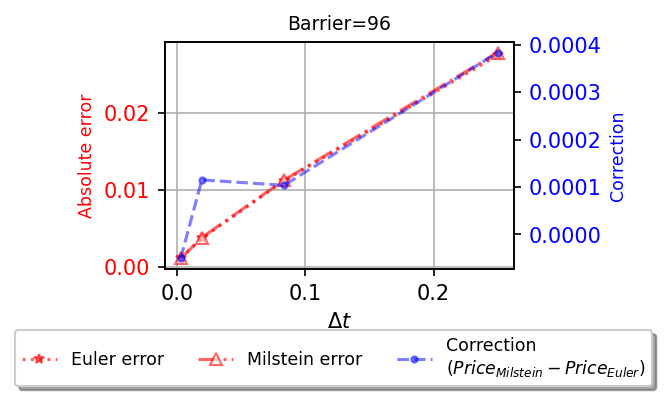

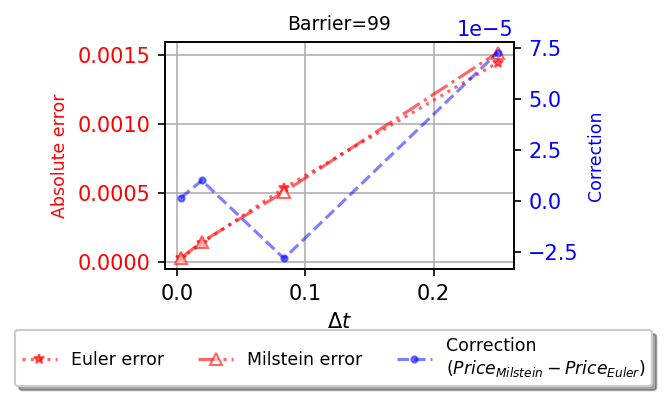

In [7]:
plotterBS(vary_interest=False, vary_bar=True)

# Heston Model

In [8]:
def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)  
        
    # reshape K to a column vector
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    #assigning i=sqrt(-1)
    i = complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # sumation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for Put Prices  
    H_k = CallPutCoefficients(CP,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))     
    return value
    #return value[0][0]

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

# Determine coefficients for Put Prices 
def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        #print('type of a:',type(a),' type of b:',type(b))
        #if (a < b) & (b < 0.0):
        if np.logical_and(a<b, b<0.0):
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)                  
    return H_k    

def ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rho):
    i = complex(0.0,1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*np.exp(-D1(u)*tau)))\
        *(kappa-gamma*rho*i*u-D1(u))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    A  = lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*u-D1(u))\
        - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
    # Characteristic function for the Heston's model    
    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf 

def GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):    
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    W2 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    #S = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    X[:,0]=np.log(S_0)
    #S[:,0]=S_0
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
            Z2[:,i] = (Z2[:,i] - np.mean(Z2[:,i])) / np.std(Z2[:,i])
        Z2[:,i] = rho * Z1[:,i] + np.sqrt(1.0-rho**2)*Z2[:,i]
        
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]
        
        # Truncated boundary condition
        V[:,i+1] = V[:,i] + kappa*(vbar - V[:,i]) * dt + gamma* np.sqrt(V[:,i]) * (W1[:,i+1]-W1[:,i])
        #V[:,i+1] = np.maximum(V[:,i+1],0.0)
        V[:,i+1] = abs(V[:,i+1])
        
        X[:,i+1] = X[:,i] + (r - 0.5*V[:,i])*dt + np.sqrt(V[:,i])*(W2[:,i+1]-W2[:,i])
        #S[:,i+1] = S[:,i] + r*S[:,i]*dt + np.sqrt(V[:,i])*S[:,i]*(W2[:,i+1]-W2[:,i])
        time[i+1] = time[i] +dt
        
    #Compute exponent
    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths

def GeneratePathsHestonMilstein(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):    
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    W2 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    S = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    S[:,0]=S_0
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
            Z2[:,i] = (Z2[:,i] - np.mean(Z2[:,i])) / np.std(Z2[:,i])
        Z2[:,i] = rho * Z1[:,i] + np.sqrt(1.0-rho**2)*Z2[:,i]
        
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]
        
        # Truncated boundary condition
        #v += kappa*(theta - v)*dt + sigma*np.sqrt(v*dt)*dZ_v[i] + 0.25*sigma**2*dt*(dZ_v[i]**2-1)
        V[:,i+1] = V[:,i] + kappa*(vbar - V[:,i]) * dt + gamma* np.sqrt(V[:,i]) * (W1[:,i+1]-W1[:,i]) + 0.25*gamma**2*((W1[:,i+1]-W1[:,i])**2 - dt)
        #V[:,i+1] = np.maximum(V[:,i+1],0.0)
        V[:,i+1] = abs(V[:,i+1])
        #S += r*S*dt + np.sqrt(v_mil[j]*dt)*S*dZ_s[j] + 0.5*v_mil[j]*S*dt*(dZ_s[j]**2-1) 
        S[:,i+1] = S[:,i] + r*S[:,i]*dt + np.sqrt(V[:,i])*S[:,i]*(W2[:,i+1]-W2[:,i]) + 0.5*V[:,i]*S[:,i]*((W2[:,i+1]-W2[:,i])**2 - dt)
        time[i+1] = time[i] +dt
        
    #Compute exponent
    #S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths


def CIR_Sample(NoOfPaths,kappa,gamma,vbar,s,t,v_s):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    sample = c* np.random.noncentral_chisquare(delta,kappaBar,NoOfPaths)
    return  sample


def GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):    
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    X[:,0]=np.log(S_0)
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i]) #standardlized
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        
        # Exact samles for the variance process
        V[:,i+1] = CIR_Sample(NoOfPaths,kappa,gamma,vbar,0,dt,V[:,i])
        k0 = (r -rho/gamma*kappa*vbar)*dt
        k1 = (rho*kappa/gamma -0.5)*dt - rho/gamma
        k2 = rho / gamma
        X[:,i+1] = X[:,i] + k0 + k1*V[:,i] + k2 *V[:,i+1] + np.sqrt((1.0-rho**2)*V[:,i])*(W1[:,i+1]-W1[:,i])
        time[i+1] = time[i] +dt
        
    #Compute exponent
    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths

def mainCalculationHES(optiontype, steps, exactBarrierPrice, vol_of_vol, reversion, long_term_vol , intrest , 
                       correlation, initial_vol, maturity, barrier , paths=20000, seed=1):
    
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    if optiontype == 'put':
        CP= OptionType.PUT
    else:
        CP= OptionType.CALL
        
    gamma = vol_of_vol #1.4 
    kappa = reversion #6 
    vbar  = long_term_vol #0.2 
    rho   = correlation #-0.7 
    v0    = initial_vol #0.2 
    T     =  maturity
    S_0   =  100.0
    r     = intrest #0.0015 
    K =   np.array([100.0])   #np.array([99.0])
    H = barrier #80
    
    NoOfSteps =steps
    # Simulated paths
    NoOfPaths = paths
    
    cf = ChFHestonModel(r,T,kappa,gamma,vbar,v0,rho)
    # Exact Put price
    exactPrice = CallPutOptionPriceCOSMthd(cf, CP, S_0, r, T, K, 1000, 8)
    #print('Exact european option price: ',exactPrice)
    #exactBarrierPrice = ExactHestonBarrier(CP, gamma, kappa, vbar, rho, v0, S_0, r, K, H,maturity)

    np.random.seed(seed)
    PathsEuler    = GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
    np.random.seed(seed)
    PathsMilstein = GeneratePathsHestonMilstein(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
    S_Euler = PathsEuler["S"]
    S_Milstein = PathsMilstein["S"]
    priceEuler, seEuler = EUOptionPriceFromMCPaths(CP,S_Euler[:,-1],K,T,r)
    priceMilstein, seMil = EUOptionPriceFromMCPaths(CP,S_Milstein[:,-1],K,T,r)
    correction_euro = priceMilstein - priceEuler
    barrierpriceEuler, seBarEuler = BarrierOptionPriceFromMCPaths(CP,S_Euler,K,T,r,H)
    barrierpriceMilstein, seBarMil = BarrierOptionPriceFromMCPaths(CP,S_Milstein,K,T,r,H)
    correction_bar = barrierpriceMilstein - barrierpriceEuler    
    return (abs(priceEuler-exactPrice), abs(priceMilstein-exactPrice), abs(barrierpriceEuler-exactBarrierPrice),
            abs(barrierpriceMilstein-exactBarrierPrice), seEuler, seMil, seBarEuler, seBarMil, correction_euro, correction_bar)

In [9]:
#Determine the exact price for Heston Barrier option using AES with large steps and no. of paths

def ExactHestonBarrier(optiontype, gamma, kappa, vbar, rho, v0, S_0, r, K, H,maturity,paths):
    assert optiontype in ['call','put'], 'optiontype should be either "call" or "put".'
    if optiontype == 'put':
        CP= OptionType.PUT
    else:
        CP= OptionType.CALL
    T = maturity
    NoOfPaths=paths
    NoOfSteps=2**10
    temp_price, temp_se = [], []
    #print('********Running simulations for Exact Heston Barrier prices with AES*******')
    for i in range(10):
        pathsAES = GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
        S_AES = pathsAES["S"]
        price, se = BarrierOptionPriceFromMCPaths(CP,S_AES,K,maturity,r,H)
        temp_price.append(price)
        temp_se.append(se)
        
    return np.mean(temp_price), np.mean(temp_se)

In [ ]:
def plotterHES(vary_interest=True, vary_vol_of_vol=False, vary_kappa=False, vary_longterm_vol=False, 
               vary_intial_vol=False, vary_correlation=False, vary_bar=False):
    step_grid = [365,52,12,4]
    
    if vary_interest:
        intrest_grid = np.linspace(0.0015, 0.05, 7)
        title = "Fixed params: $\gamma=1.4,\kappa=6,\\rho =-0.7,\overline{v}=0.2,v_0=0.2$"
        display(HTML('<font size="6"><strong>{}</font></strong>'.format(title)))
        exactBarrierPrices = [ExactHestonBarrier(optiontype='call', gamma=1.4, kappa=6,vbar=0.2, rho=-0.7, v0=0.2, 
                                       S_0=100, r=i, K=100, H=80, maturity=1,paths=120000)[0] for i in intrest_grid]
        for r_,exactBar in zip(intrest_grid, exactBarrierPrices):
            err_eu, err_mil , errBar_eu, errBar_mil, correctionEuro, correctionBar = [], [], [], [], [], [] 
            for i in step_grid:
                temp_eu, temp_mil, tempBar_eu, tempBar_mil, tempCorrection, tempBarCorrection = [], [], [], [], [], []
                
                for j in range(10):
                    res = mainCalculationHES(optiontype='call',steps=i,exactBarrierPrice=exactBar, vol_of_vol=1.4, reversion=6,
                                             long_term_vol = 0.2,intrest = r_,correlation = -0.7, initial_vol =0.2, maturity =1,
                                             barrier=80, paths=100000, seed=np.random.randint(1,100)) 

                    temp_eu.append(res[0])
                    temp_mil.append(res[1])
                    tempBar_eu.append(res[2])
                    tempBar_mil.append(res[3])
                    tempCorrection.append(res[8])
                    tempBarCorrection.append(res[9])

                err_eu.append(np.mean(temp_eu))
                err_mil.append(np.mean(temp_mil)) 
                errBar_eu.append(np.mean(tempBar_eu))
                errBar_mil.append(np.mean(tempBar_mil))
                correctionEuro.append(np.mean(tempCorrection))
                correctionBar.append(np.mean(tempBarCorrection))
        
            generic_plotter(euler_err=err_eu, mil_err=err_mil,correction_euro = correctionEuro,
                            eulerBar_err=errBar_eu, milBar_err=errBar_mil, correction_barrier = correctionBar,
                            param_grid=intrest_grid, param_val=r_, fig_title='r')

            
    if vary_vol_of_vol:
        vol_of_vol_grid = np.linspace(0.1,1.6,9)
        title = "Fixed params: $r=1\%,\kappa=6,\\rho =-0.7,\overline{v}=0.2,v_0=0.2$"
        display(HTML('<font size="6"><strong>{}</font></strong>'.format(title)))
        exactBarrierPrices = [ExactHestonBarrier(optiontype='call', gamma=i, kappa=6,vbar=0.2, rho=-0.7, v0=0.2, 
                                       S_0=100, r=0.01, K=100, H=80, maturity=1,paths=120000)[0] for i in vol_of_vol_grid]
        
        for v, exactBar in zip(vol_of_vol_grid, exactBarrierPrices):
            err_eu, err_mil , errBar_eu, errBar_mil, correctionEuro, correctionBar = [], [], [], [], [], [] 
            for i in step_grid:
                temp_eu, temp_mil, tempBar_eu, tempBar_mil, tempCorrection, tempBarCorrection = [], [], [], [], [], []
                for j in range(10):
                    res = mainCalculationHES(optiontype='call',steps=i,exactBarrierPrice=exactBar, vol_of_vol=v, reversion=6,
                                             long_term_vol = 0.2,intrest = 0.01, correlation = -0.7, initial_vol =0.2, maturity =1,
                                             barrier=80, paths=100000, seed=np.random.randint(1,100)) 

                    temp_eu.append(res[0])
                    temp_mil.append(res[1])
                    tempBar_eu.append(res[2])
                    tempBar_mil.append(res[3])
                    tempCorrection.append(res[8])
                    tempBarCorrection.append(res[9])

                err_eu.append(np.mean(temp_eu))
                err_mil.append(np.mean(temp_mil)) 
                errBar_eu.append(np.mean(tempBar_eu))
                errBar_mil.append(np.mean(tempBar_mil))
                correctionEuro.append(np.mean(tempCorrection))
                correctionBar.append(np.mean(tempBarCorrection))
        
            generic_plotter(euler_err=err_eu, mil_err=err_mil, correction_euro = correctionEuro,
                            eulerBar_err=errBar_eu, milBar_err=errBar_mil, correction_barrier = correctionBar,
                            param_grid=vol_of_vol_grid, param_val=v, fig_title='gamma')
   
            
    if vary_kappa:
        kappa_grid = np.arange(1,8)
        title = "Fixed params: $\gamma=1,r=1\%,\\rho =-0.7,\overline{v}=0.2,v_0=0.2$"
        display(HTML('<font size="6"><strong>{}</font></strong>'.format(title)))
        exactBarrierPrices = [ExactHestonBarrier(optiontype='call', gamma=1, kappa=i,vbar=0.2, rho=-0.7, v0=0.2, 
                                       S_0=100, r=0.01, K=100, H=80, maturity=1,paths=120000)[0] for i in kappa_grid]

        for k, exactBar in zip(kappa_grid, exactBarrierPrices):
            err_eu, err_mil , errBar_eu, errBar_mil, correctionEuro, correctionBar = [], [], [], [], [], []
            for i in step_grid:
                temp_eu, temp_mil, tempBar_eu, tempBar_mil, tempCorrection, tempBarCorrection = [], [], [], [], [], []
                for j in range(10):
                    res = mainCalculationHES(optiontype='call',steps=i,exactBarrierPrice=exactBar, vol_of_vol=1, reversion=k,
                                             long_term_vol = 0.2,intrest = 0.01, correlation = -0.7, initial_vol =0.2, 
                                             maturity =1, barrier=80, paths=100000, seed=np.random.randint(1,100)) 

                    temp_eu.append(res[0])
                    temp_mil.append(res[1])
                    tempBar_eu.append(res[2])
                    tempBar_mil.append(res[3])
                    tempCorrection.append(res[8])
                    tempBarCorrection.append(res[9])

                err_eu.append(np.mean(temp_eu))
                err_mil.append(np.mean(temp_mil)) 
                errBar_eu.append(np.mean(tempBar_eu))
                errBar_mil.append(np.mean(tempBar_mil))
                correctionEuro.append(np.mean(tempCorrection))
                correctionBar.append(np.mean(tempBarCorrection))

            generic_plotter(euler_err=err_eu, mil_err=err_mil, correction_euro = correctionEuro, 
                            eulerBar_err=errBar_eu, milBar_err=errBar_mil, correction_barrier = correctionBar,
                            param_grid=kappa_grid, param_val=k, fig_title='kappa')
            
    if vary_longterm_vol:
        longterm_vol_grid = np.linspace(0.1,0.65,6) 
        title = "Fixed params: $\gamma=1,r=1\%,\kappa=2, \\rho =-0.7,v_0=0.2$"
        display(HTML('<font size="6"><strong>{}</font></strong>'.format(title)))
        exactBarrierPrices = [ExactHestonBarrier(optiontype='call', gamma=1, kappa=2,vbar=i, rho=-0.7, v0=0.2, 
                                       S_0=100, r=0.01, K=100, H=80, maturity=1,paths=120000)[0] for i in longterm_vol_grid]
        
        for vbar, exactBar in zip(longterm_vol_grid, exactBarrierPrices):
            err_eu, err_mil , errBar_eu, errBar_mil, correctionEuro, correctionBar = [], [], [], [], [], []
            for i in step_grid:
                temp_eu, temp_mil, tempBar_eu, tempBar_mil, tempCorrection, tempBarCorrection = [], [], [], [], [], []
                for j in range(10):
                    res = mainCalculationHES(optiontype='call',steps=i,exactBarrierPrice=exactBar, vol_of_vol=1, reversion=2,
                                             long_term_vol = vbar, intrest = 0.01, correlation = -0.7, initial_vol =0.2, 
                                             maturity =1, barrier=80, paths=100000, seed=np.random.randint(1,100)) 

                    temp_eu.append(res[0])
                    temp_mil.append(res[1])
                    tempBar_eu.append(res[2])
                    tempBar_mil.append(res[3])
                    tempCorrection.append(res[8])
                    tempBarCorrection.append(res[9])

                err_eu.append(np.mean(temp_eu))
                err_mil.append(np.mean(temp_mil)) 
                errBar_eu.append(np.mean(tempBar_eu))
                errBar_mil.append(np.mean(tempBar_mil))
                correctionEuro.append(np.mean(tempCorrection))
                correctionBar.append(np.mean(tempBarCorrection))

            generic_plotter(euler_err=err_eu, mil_err=err_mil, correction_euro = correctionEuro,  
                            eulerBar_err=errBar_eu, milBar_err=errBar_mil, correction_barrier = correctionBar,
                            param_grid=longterm_vol_grid, param_val= vbar, fig_title='vbar')
    '''    
    if vary_intial_vol:
        intial_vol_grid = 
        
    if vary_correlation:
        correlation_grid = 
        
    if vary_bar:
        
    else:
        print('All parameters were set False. Set anyone to True!!')'''

#### Yuhao

In [ ]:
plotterHES(vary_interest=True)

#### Yuhao

In [ ]:
plotterHES(vary_interest=False, vary_vol_of_vol=True)

#### Yuhao

In [ ]:
plotterHES(vary_interest=False, vary_kappa=True)

#### Zhiyu (1st run this)

In [ ]:
plotterHES(vary_interest=False,  vary_longterm_vol=True)